# lib imports

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score

import numpy as np
import os
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Feature Selection

In [ ]:
raw = pd.read_csv('/content/drive/MyDrive/COMM557 Group Project/machine learning part/cleaned_listings.csv')
raw.shape

(25800, 52)

## training testing sets

In [ ]:
raw = pd.read_csv('/content/drive/MyDrive/COMM557 Group Project/machine learning part/cleaned_listings.csv')
df = raw[~raw['price'].isin([999, 9999])]


# drop relatively irrelevant columns
df = df.drop(['host_listings_count', 'host_total_listings_count', 'minimum_nights_avg_ntm','maximum_minimum_nights','minimum_nights','minimum_minimum_nights', 'property_type',
              'calculated_host_listings_count_shared_rooms','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','maximum_nights_avg_ntm','cnt_amenities'], axis=1)


# df['has_availability'].value_counts()

# convert host_response_time from categorical variable to numerical one
df['host_response_time'] = df['host_response_time'].replace({
    'within an hour': 1,
    'within a few hours': 5,
    'within a day': 12,
    'a few days or more': 48
})
# df['host_response_time'].value_counts()

# added 'has_availability'
categorical_cols = [ 'neighbourhood_cleansed',
                    # 'property_type',
                     'room_type','has_availability']  # add more if needed
# categorical_cols = ['host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type']  # add more if needed
for col in categorical_cols:
    df[col] = df[col].astype('category')

X = df.drop(columns=['id','source','name','host_id','host_name','host_is_superhost'])
y = df['host_is_superhost']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
y.value_counts()

0    13545
1    12242
Name: host_is_superhost, dtype: int64

In [ ]:
print(len(X_train),len(X_test))

20629 5158


In [ ]:
# print(X_train.head())
# print(X_train.columns)

       host_response_time  host_response_rate  host_acceptance_rate  \
11184                   1                0.99                  0.99   
6911                    5                1.00                  0.96   
4292                    1                1.00                  1.00   
21090                   1                1.00                  0.80   
17105                   5                1.00                  1.00   

       host_has_profile_pic  host_identity_verified neighbourhood_cleansed  \
11184                     1                       1               Westlake   
6911                      1                       1               Palmdale   
4292                      1                       1     Northwest Palmdale   
21090                     1                       1                 Venice   
17105                     1                       1             Pico-Union   

             room_type  accommodates  price  maximum_nights  ...  \
11184  Entire home/apt            10

## Use XGBoost Classifier to Select Top20 Features

1.   清單項目
2.   清單項目



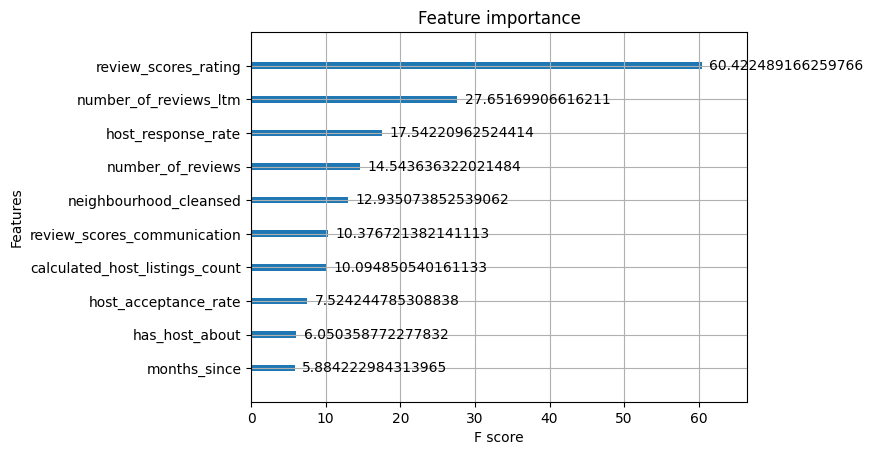

In [ ]:
# during

# Train XGBoost model
# Supported tree methods are `approx` and `hist`for categorical data.

model = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)
model.fit(X_train, y_train)

# Get feature importances
xgb_importances = model.feature_importances_

# Plot
xgb.plot_importance(model, max_num_features=10,importance_type='gain')
plt.show()

# Get the top 20 feature indices
sorted_idx = np.argsort(xgb_importances)[::-1]
top_20_features = sorted_idx[:10]

In [ ]:
print(X_train.columns[top_20_features])

Index(['review_scores_rating', 'number_of_reviews_ltm', 'host_response_rate',
       'number_of_reviews', 'neighbourhood_cleansed',
       'review_scores_communication', 'calculated_host_listings_count',
       'host_acceptance_rate', 'has_host_about', 'months_since'],
      dtype='object')


In [ ]:
# Multi-variable regression

# df_updated = df.drop(columns=['id','source','name','host_id','host_name','host_is_superhost'])
# feature_selected_df = df_updated[df_updated.columns[top_20_features]] # it's actually only the top 10 features

# Manually selected variables
feature_selected_df = df[[
    # 'host_response_time',
    'host_response_rate', 'host_acceptance_rate', 'host_has_profile_pic', 'host_identity_verified',
    'neighbourhood_cleansed',
    'number_of_reviews',
    # 'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'review_scores_rating',
    # 'review_scores_accuracy', 'review_scores_value'
    # 'review_scores_cleanliness', 'review_scores_checkin', # highly correlated w/ review_scores_communication
    # 'review_scores_communication','review_scores_location',
    'calculated_host_listings_count', 'reviews_per_month','cnt_verifications','months_since']]

# ## Find inter-correlation to further filter varibles
# # Extract the dependent variable (y) and independent variables (X)
# y = feature_selected_df['review_scores_rating']
# X = feature_selected_df.drop(columns=['review_scores_rating'])

# # Handle categorical variable using one-hot encoding
# X = pd.get_dummies(X, columns=['neighbourhood_cleansed'], drop_first=True)

# # Concatenate the dependent variable and independent variables
# df = pd.concat([y, X], axis=1)

# # Calculate the correlation matrix
# correlation_matrix = df.corr()

# # Set a threshold for high correlation (adjust as needed)
# high_corr_threshold = 0.7

# # Filter the correlation matrix to include only pairs with high correlation
# high_corr_pairs = [(i, j) for i in correlation_matrix.columns for j in correlation_matrix.columns if i != j and abs(correlation_matrix.loc[i, j]) > high_corr_threshold]

# # Print the pairs with high correlation
# for pair in high_corr_pairs:
#     var1, var2 = pair
#     corr_value = correlation_matrix.loc[var1, var2]
#     print(f'{var1} and {var2}: {corr_value:.2f}')



import pandas as pd
import statsmodels.api as sm


# Extract the dependent variable (y) and independent variables (X)
y = feature_selected_df['review_scores_rating']
X = feature_selected_df.drop(columns=['review_scores_rating'])

# Handle categorical variable using one-hot encoding
X = pd.get_dummies(X, columns=['neighbourhood_cleansed','host_has_profile_pic', 'host_identity_verified'], drop_first=True)
# X = pd.get_dummies(X, columns=['host_has_profile_pic', 'host_identity_verified'], drop_first=True)

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the summary of the regression
summary = model.summary()

# Print out the summary with significance stars
print(summary)


# Print significance stars
def print_significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''


# Extract coefficients and p-values for each variable
results_data = summary.tables[1].data[1:]

# Print significant results only
for row in results_data:
    variable = row[0]
    coefficient = float(row[1])
    p_value = float(row[4])

    # Check if the p-value is less than the significance level (e.g., 0.05)
    if p_value < 0.05:
        stars = print_significance_stars(p_value)
        sign = '+' if coefficient > 0 else '-'  # Check the sign of the coefficient
        result_str = f'{variable}: ({sign}) {stars}'
        print(result_str)

                             OLS Regression Results                             
Dep. Variable:     review_scores_rating   R-squared:                       0.103
Model:                              OLS   Adj. R-squared:                  0.094
Method:                   Least Squares   F-statistic:                     10.93
Date:                  Tue, 28 Nov 2023   Prob (F-statistic):               0.00
Time:                          05:30:46   Log-Likelihood:                -15689.
No. Observations:                 25787   AIC:                         3.192e+04
Df Residuals:                     25517   BIC:                         3.412e+04
Df Model:                           269                                         
Covariance Type:              nonrobust                                         
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [ ]:
X_train[X_train.columns[top_20_features]].head(20)

,review_scores_rating,number_of_reviews_ltm,host_response_rate,number_of_reviews,neighbourhood_cleansed,review_scores_communication,calculated_host_listings_count,host_acceptance_rate,has_host_about,months_since
11184,5.00,1,0.99,1,Westlake,5.00,18,0.99,1,44
6911,4.94,3,1.00,33,Palmdale,4.97,2,0.96,1,96
4292,5.00,1,1.00,1,Northwest Palmdale,5.00,2,1.00,1,14
21090,4.64,0,1.00,62,Venice,4.79,1,0.80,1,143
17105,4.50,0,1.00,3,Pico-Union,4.50,6,1.00,1,77
16139,5.00,3,0.88,5,Hollywood Hills,5.00,1,0.55,0,122
24746,5.00,0,0.97,1,Westchester,5.00,103,0.82,1,53
6730,4.96,0,0.57,24,Westlake,5.00,17,0.00,1,95
2928,4.90,45,1.00,197,Alhambra,4.96,1,0.96,1,84
19919,4.89,1,1.00,129,Sawtelle,4.97,25,1.00,1,128


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Assuming you've already loaded and preprocessed your data as in your provided code

# Select the top 20 features
selected_features = X_train.columns[top_20_features]

# Select categorical columns
# categorical_cols = ['property_type', 'neighbourhood_cleansed']
categorical_cols = [ 'neighbourhood_cleansed', 'has_host_about']


# Select the remaining non-categorical columns
non_categorical_cols = [col for col in selected_features if col not in categorical_cols]

# Create transformers for categorical and non-categorical columns
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', 'passthrough', non_categorical_cols)
    ])

# Initialize the Decision Tree model within a pipeline
dt_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])


# # Print shapes before fitting the model
# print("X_train[selected_features] shape:", X_train[selected_features].shape)
# print("y_train shape:", y_train.shape)

# Train the Decision Tree model
dt_model.fit(X_train[selected_features], y_train)


# Make predictions on the test set
y_pred_dt = dt_model.predict(X_test[selected_features])

# Evaluate performance
accuracy_dt = accuracy_score(y_test, y_pred_dt)

print(f"Decision Tree Accuracy: {accuracy_dt}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


Decision Tree Accuracy: 0.7675455602946879

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78      2749
           1       0.75      0.75      0.75      2409

    accuracy                           0.77      5158
   macro avg       0.77      0.77      0.77      5158
weighted avg       0.77      0.77      0.77      5158


Confusion Matrix:
 [[2146  603]
 [ 596 1813]]


In [ ]:
print("Number of data points in the training set:", X_train.shape[0])
print("Number of data points in the test set:", X_test.shape[0])


Number of data points in the training set: 20629
Number of data points in the test set: 5158


In [ ]:
#  cross-validation w/ feature importances

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


# Print the number of data points
print("Number of data points in the training set:", X_train.shape[0])
print("Number of data points in the test set:", X_test.shape[0])

# Select the top 20 features
selected_features = X_train.columns[top_20_features]

# Select categorical columns
# categorical_cols = ['property_type', 'neighbourhood_cleansed']
categorical_cols = [ 'neighbourhood_cleansed','has_host_about']

# Select the remaining non-categorical columns
non_categorical_cols = [col for col in selected_features if col not in categorical_cols]

# Create transformers for categorical and non-categorical columns
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', 'passthrough', non_categorical_cols)
    ])

# Initialize the Decision Tree model within a pipeline
dt_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(dt_model, X[selected_features], y, cv=cv_strategy, scoring='accuracy')

# Print cross-validated scores
print("Cross-Validated Accuracy Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

# Train the Decision Tree model on the entire training set
dt_model.fit(X_train[selected_features], y_train)

# Access feature importances
feature_importances = dt_model.named_steps['classifier'].feature_importances_

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(selected_features, feature_importances):
    print(f"{feature}: {importance}")

# Make predictions on the test set
y_pred_dt = dt_model.predict(X_test[selected_features])

# Evaluate performance
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print('-----------')
print(f"Decision Tree Accuracy: {accuracy_dt}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Number of data points in the training set: 20629
Number of data points in the test set: 5158
Cross-Validated Accuracy Scores: [0.76463746 0.77394339 0.77099089 0.76401008 0.77389955]
Mean Accuracy: 0.7694962737698162
Feature Importances:
review_scores_rating: 0.0
number_of_reviews_ltm: 0.00035666324934566804
host_response_rate: 0.000625042550407331
number_of_reviews: 0.00027036558122822647
neighbourhood_cleansed: 0.0025243624659598536
review_scores_communication: 6.859343527302328e-05
calculated_host_listings_count: 0.0015849699040805657
host_acceptance_rate: 0.00017937716446872706
has_host_about: 0.0011018146811521995
months_since: 0.0
-----------
Decision Tree Accuracy: 0.7675455602946879

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78      2749
           1       0.75      0.75      0.75      2409

    accuracy                           0.77      5158
   macro avg       0.77      0.77      0.77      5158
wei

In [ ]:
# random forest

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Select the top 20 features
selected_features = X_train.columns[top_20_features]

# Select categorical columns
# categorical_cols = ['property_type', 'neighbourhood_cleansed']
categorical_cols = ['neighbourhood_cleansed','has_host_about']

# Select the remaining non-categorical columns
non_categorical_cols = [col for col in selected_features if col not in categorical_cols]


# Create transformers for categorical and non-categorical columns
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', 'passthrough', non_categorical_cols)
    ])


# Initialize the Random Forest model within a pipeline
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X[selected_features], y, cv=cv_strategy, scoring='accuracy')

# Print cross-validated scores
print("Cross-Validated Accuracy Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

# Train the Random Forest model on the entire training set
rf_model.fit(X_train[selected_features], y_train)

# Access feature importances
feature_importances = rf_model.named_steps['classifier'].feature_importances_

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(selected_features, feature_importances):
    print(f"{feature}: {importance}")

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test[selected_features])

# Evaluate performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {accuracy_rf}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Cross-Validated Accuracy Scores: [0.84024816 0.83171772 0.83575722 0.82858251 0.83614505]
Mean Accuracy: 0.8344901312438143
Feature Importances:
review_scores_rating: 5.516166556883285e-05
number_of_reviews_ltm: 0.00028105208936947764
host_response_rate: 0.0007539662711324916
number_of_reviews: 0.0002560622783104718
neighbourhood_cleansed: 0.0029686618016684816
review_scores_communication: 0.00019425185719868917
calculated_host_listings_count: 0.001552071222461486
host_acceptance_rate: 8.87374776328446e-05
has_host_about: 0.0017161186989466035
months_since: 4.265506396695915e-05
Random Forest Accuracy: 0.8359829391236914

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85      2749
           1       0.83      0.81      0.82      2409

    accuracy                           0.84      5158
   macro avg       0.84      0.83      0.84      5158
weighted avg       0.84      0.84      0.84      5158


Confusion Matrix:


# Use the Selected Feautures in different models

In [ ]:
# Create a k-fold cross-validator object (e.g., 5-fold)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Keep only top20 features in the original dataset
X = X.iloc[:, top_20_features]

## XGBoost hist tree

In [ ]:
# Initialize the model
model_xgb = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)

# Compute cross-validated accuracy scores
cv_scores = cross_val_score(model_xgb, X, y, cv=kf, scoring='accuracy')

# Print results
print('XGBoost hist tree')
print(f"Accuracy scores for the 5 folds: {cv_scores}")
print(f"Mean accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard deviation: {np.std(cv_scores):.4f}")


XGBoost hist tree
Accuracy scores for the 5 folds: [0.87029857 0.86041101 0.86038394 0.86290479 0.8596083 ]
Mean accuracy: 0.8627
Standard deviation: 0.0039


In [ ]:

def cv_score(X, y):
    return cross_val_score(model, X, y, cv=kf, scoring='accuracy').mean()
remaining_features = list(X.columns)
best_score = cv_score(X[remaining_features], y)
eliminated_features = []

while len(remaining_features) > 3:  # assuming you want at least one feature
    scores_with_dropped = []

    for feature in remaining_features:
        score = cv_score(X[remaining_features].drop(feature, axis=1), y)
        scores_with_dropped.append((feature, score))

    # Find the feature whose removal gives the best score
    feature_to_remove, best_score_with_dropped = max(scores_with_dropped, key=lambda x: x[1])

    if best_score_with_dropped > best_score:
        # Remove the feature and update the best score
        remaining_features.remove(feature_to_remove)
        eliminated_features.append(feature_to_remove)
        best_score = best_score_with_dropped
    else:
        # If removing any feature does not improve the score, break the loop
        break

print(f"Selected features: {remaining_features}")
print(f"Eliminated features: {eliminated_features}")
print(f"Best cross-validated score: {best_score:.4f}")



Selected features: ['review_scores_rating', 'number_of_reviews_ltm', 'number_of_reviews', 'host_response_rate', 'minimum_nights_avg_ntm', 'neighbourhood_cleansed', 'host_listings_count', 'review_scores_communication', 'host_total_listings_count', 'calculated_host_listings_count_private_rooms', 'host_acceptance_rate', 'review_scores_accuracy', 'calculated_host_listings_count', 'has_host_about', 'cnt_amenities', 'calculated_host_listings_count_entire_homes', 'minimum_nights', 'review_scores_cleanliness', 'months_since', 'maximum_minimum_nights']
Eliminated features: []
Best cross-validated score: 0.8627


https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7